# Урок 8. GAN

## Практическое задание

Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [8]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist_digits = np.concatenate([x_train, x_test], axis=0)
fashion_mnist_digits = np.expand_dims(fashion_mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 21s 21ms/step - loss: 351.2630 - reconstruction_loss: 347.9501 - kl_loss: 3.3129
Epoch 2/10
547/547 [==============================] - 10s 19ms/step - loss: 310.9500 - reconstruction_loss: 307.0396 - kl_loss: 3.9104
Epoch 3/10
547/547 [==============================] - 10s 19ms/step - loss: 303.5050 - reconstruction_loss: 300.0640 - kl_loss: 3.4411
Epoch 4/10
547/547 [==============================] - 10s 19ms/step - loss: 300.1801 - reconstruction_loss: 296.9530 - kl_loss: 3.2271
Epoch 5/10
547/547 [==============================] - 10s 19ms/step - loss: 297.6570 - reconstruction_loss: 294.5793 - kl_loss: 3.0776
Epoch 6/10
547/547 [==============================] - 10s 19ms/step - loss: 296.2333 - reconstruction_loss: 293.2407 - kl_loss: 2.9926
Epoch 7/10
547/547 [==============================] - 11s 19ms/step - loss: 295.0902 - reconstruction_loss: 292.1362 - kl_loss: 2.9540
Epoch 8/10
547/547 [==============================] - 1

In [10]:
vae.fit(fashion_mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 13s 24ms/step - loss: 292.5846 - reconstruction_loss: 289.7305 - kl_loss: 2.8541
Epoch 2/10
547/547 [==============================] - 10s 18ms/step - loss: 291.9884 - reconstruction_loss: 289.1235 - kl_loss: 2.8650
Epoch 3/10
547/547 [==============================] - 10s 19ms/step - loss: 291.5286 - reconstruction_loss: 288.6826 - kl_loss: 2.8460
Epoch 4/10
547/547 [==============================] - 10s 19ms/step - loss: 290.7901 - reconstruction_loss: 287.9589 - kl_loss: 2.8312
Epoch 5/10
547/547 [==============================] - 10s 19ms/step - loss: 290.5843 - reconstruction_loss: 287.7534 - kl_loss: 2.8309
Epoch 6/10
547/547 [==============================] - 10s 19ms/step - loss: 290.2381 - reconstruction_loss: 287.4130 - kl_loss: 2.8251
Epoch 7/10
547/547 [==============================] - 10s 18ms/step - loss: 289.8033 - reconstruction_loss: 286.9757 - kl_loss: 2.8275
Epoch 8/10
547/547 [==============================] - 1

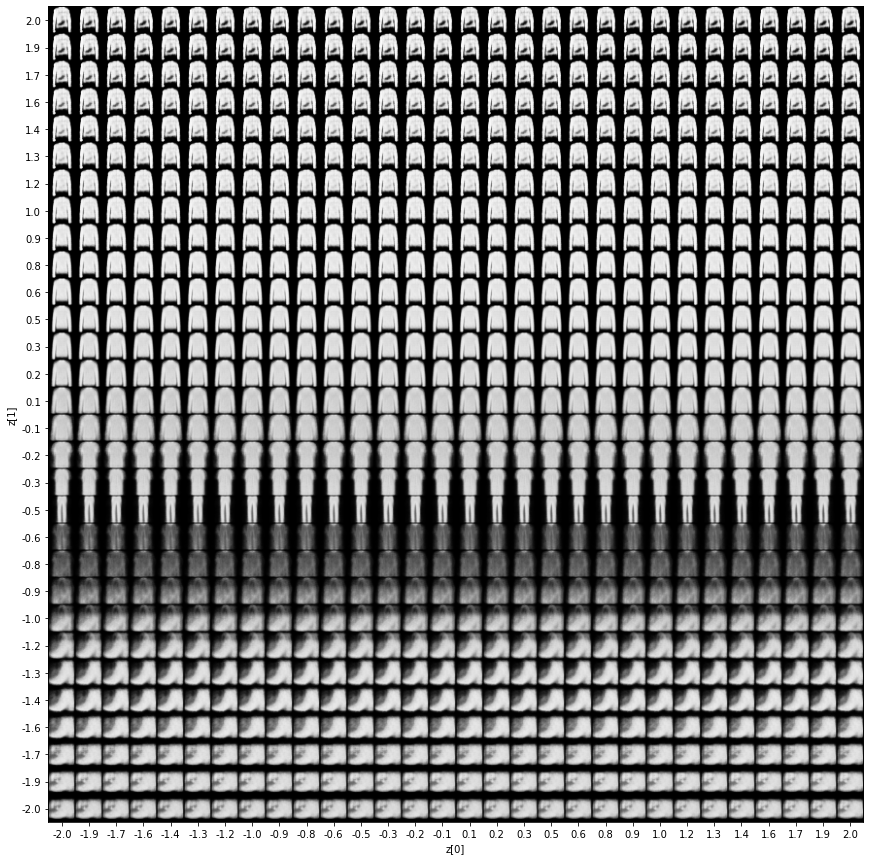

In [11]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

Vae содзает переходные объекты между объектами.

Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 

StackGAN − порождающая состязательная сеть для генерации фото-реалистичных изображений исходя из текстового описания. Из-за трудности генерации изображений используеется две стадии генерерации. Первая стадия создает изображение из текста в плохом качестве, вторая улучшае это изображение. Ключевой особенностью StackGAN является Conditioning Augmentation, так как оно позволило расширить количество примеров тренировочного сета, путем небольших случайных изменений в исходных изображениях, что увеличивало многообразие данных.В изображениях с низким разрешенеим, сгенерированные Stage-I GAN, обычно недостает ярких деталей и могут быть искривления форм, некоторые детали изображения также могут быть опущены на первом этапе. Stage-II GAN построен над Stage-I GAN и принимает на вход его выход, и текстовое описание, чтобы исправить и дополнить изображение. При этом Stage-I GAN и Stage-II GAN имеют разные полно-связные слои, чтобы отличаться по среднему значению и стандартному отклонению, таким образом на разных этапах фокусируюемся на разных деталях исходного текста